In [2]:
import nengo
import nengo.spa as spa

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from utils import gen_vecs
from data_feed import BasicDataFeed

import itertools
import random

In [3]:
n_items = 4
t_present = 0.5
pause = 0.1
D = 16
dt = 0.001
similarity = 0.9999

recog_neurons = 500
seed = 0
spikes_synapse = 0.005

t_train = (t_present+pause)*n_items
t_test = 2*(t_present+pause)*n_items

In [4]:
vocab = spa.Vocabulary(D)

targ_class = []

stim_vecs = gen_vecs(n_items, D, similarity)
stim_lbl = []

for v_i, vec in enumerate(stim_vecs):
    lbl = "S%d" % v_i
    stim_lbl.append(lbl)
    vocab.add(lbl, vec)

    targ = np.zeros(n_items)
    targ[v_i] = 1
    targ_class.append(targ)

print(stim_lbl)

for s1, s2 in itertools.combinations(stim_lbl, 2):
    print(np.dot(vocab.parse(s1).v, vocab.parse(s2).v))

['S0', 'S1', 'S2', 'S3']
0.9999
0.9999
0.9999
0.9999
0.9999
0.9999


In [5]:
def vocab_feed(idx, t):
    return vocab.parse(stim_lbl[idx]).v

# Associative Memory with Feedback

In [13]:
df = BasicDataFeed(vocab_feed, np.eye(n_items), t_present, D, n_items, pause)

with nengo.Network() as model:
    in_nd = nengo.Node(df.feed)
    cor = nengo.Node(df.get_answer)

    assoc = nengo.networks.AssociativeMemory(input_vectors=stim_vecs, seed=seed)
    assoc.add_wta_network()
    
    nengo.Connection(in_nd, assoc.input, synapse=None)
    nengo.Connection(assoc.output, assoc.input, synapse=0.1, transform=1)
    
    p_in = nengo.Probe(in_nd, synapse=None)
    p_out = nengo.Probe(assoc.output)
    p_cor = nengo.Probe(cor)

In [14]:
with nengo.Simulator(model) as sim:
    sim.run(t_train)

Building finished in 0:00:01.

Simulating finished in 0:00:01.

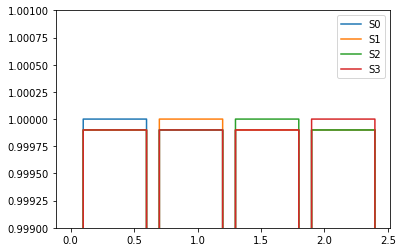

In [15]:
plt.plot(sim.trange(), spa.similarity(sim.data[p_in], stim_vecs))
plt.ylim(0.999, 1.001)
plt.legend(stim_lbl)

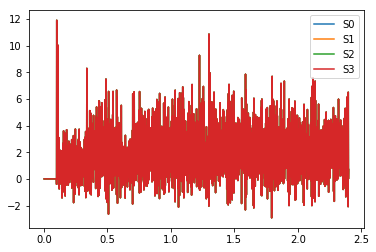

In [16]:
plt.plot(sim.trange(), spa.similarity(sim.data[p_out], stim_vecs))
plt.legend(stim_lbl)